In [18]:
# Faster RCNN

import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as transforms
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm 
import math
import coremltools as ct

In [2]:
IMAGE_PATH = 'face-mask-detection/images'
XML_PATH = 'face-mask-detection/annotations'

# filtering due to some jupyter notebook metafiles causing havoc
images = list(sorted(filter(lambda x: os.path.splitext(x)[1] == '.png', os.listdir(IMAGE_PATH))))
xmls = list(sorted(filter(lambda x: os.path.splitext(x)[1] == '.xml', os.listdir(XML_PATH))))

print(images[0])
print(xmls[0])

maksssksksss0.png
maksssksksss0.xml


In [3]:
def parse_annot(xml):
    bbox = []
    labels = []
    
    label_map = {
        'without_mask': 1,
        'with_mask': 2,
        'mask_weared_incorrect': 3 
    }
    
    tree = ET.parse(xml)
    root = tree.getroot()
    
    for box in root.iter('object'):
        bbox.append(
               [
                   int(box.find('bndbox/xmin').text),
                   int(box.find('bndbox/ymin').text),
                   int(box.find('bndbox/xmax').text),
                   int(box.find('bndbox/ymax').text),
               ]
        )
        labels.append(
            label_map[box.find('name').text]
        )
    
    return bbox, labels

def draw_boxes(img, bbox, labels):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    color_label = {
        1: (255, 0, 0),
        2: (0, 255, 0),
        3: (0, 0, 255)
    }
    
    for (x, y, w, h), label in zip(bbox, labels):
        x, y, w, h = [int(n) for n in [x, y, w, h]]
        cv2.rectangle(img, (x,y), (w,h), color_label[label], 1)
        
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    

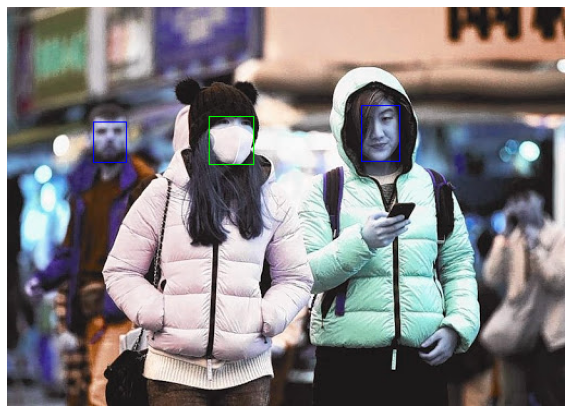

In [4]:
bbox, labels = parse_annot(os.path.join(XML_PATH, xmls[0]))

img = draw_boxes(cv2.imread(os.path.join(IMAGE_PATH, images[0])), bbox, labels)
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.axis('off')
ax.imshow(img)

In [5]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, xml_dir, img_files, xml_files):
        self.img_dir = img_dir
        self.xml_dir = xml_dir
        self.img_files = img_files
        self.xml_files = xml_files

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.img_dir, self.img_files[idx]))
        image = transforms.ToTensor()(image)
        
        bbox, labels = parse_annot(os.path.join(self.xml_dir, self.xml_files[idx]))
        
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels
        }
        
        return image, target

In [6]:
mask_dataset = ImageDataset(IMAGE_PATH, XML_PATH, images, xmls)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = torch.utils.data.DataLoader(
    mask_dataset,
    batch_size=4,
    collate_fn=collate_fn
)

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)

In [9]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,momentum=0.9, weight_decay=0.0005)

In [10]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch)

In [ ]:
torch.save(model.state_dict(),'./masknet.pth')

In [ ]:
checkpoint = torch.load('./masknet-10e.pth', map_location=device)
model.load_state_dict(checkpoint)

In [22]:
def rcnn_predict_img(img, nm_thrs=0.3, score_thrs=0.8):
    img = transforms.ToTensor()(img)
    model.eval()
    
    with torch.no_grad():
        predictions = model(img.unsqueeze(0))
        
    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(), predictions[0]['scores'].cpu(), nm_thrs)
    
    # Only display the bounding boxes which higher than the threshold
    score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    
    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
    return test_boxes, test_labels

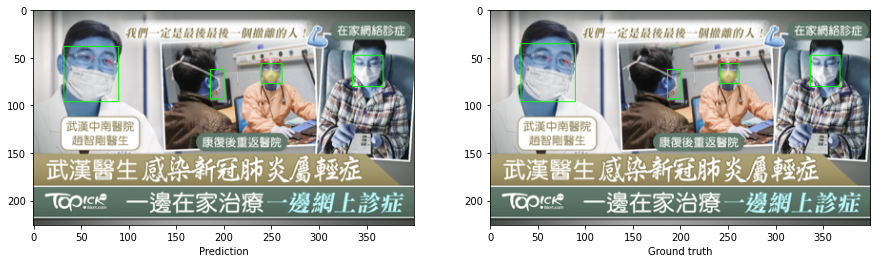

In [30]:
idx = 600

img = cv2.imread(os.path.join(IMAGE_PATH, images[idx]))
xml = os.path.join(XML_PATH, xmls[idx])

boxes, labels = rcnn_predict_img(img)

img1 = draw_boxes(img, boxes, labels)

boxes, labels = parse_annot(xml)
img2 = draw_boxes(img, boxes, labels)

# Display the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(img1)
ax1.set_xlabel('Prediction')
ax2.imshow(img2)
ax2.set_xlabel('Ground truth')
plt.show()

In [31]:
cv2.namedWindow("preview")
vc = cv2.VideoCapture(0)

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

cv2.startWindowThread()

while rval:
    boxes, labels = rcnn_predict_img(frame)
    frame = draw_boxes(frame, boxes, labels)
    cv2.imshow("preview", frame)
    rval, frame = vc.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break

vc.release()
cv2.destroyAllWindows()
for i in range (1, 5): # hack to get openCV2 to close the window
    cv2.waitKey(1)